*****************************************************************
#  Research paper
- Authors: Paul Koks, Izzie He, Lisanne van Vliet, Sam Slotemaker
- Master track: Information Sciences - VU Amsterdam
- Course: The Social Web
- 22 december 2024
- TAs: Sandro Barres-Hamers, Alexander Schmatz, Márton Bodó and Danae Mitsea.
- Professor: Dr. Davide Ceolin
*****************************************************************

## Installing the needed packages
The following 2 cells install and import the needed packages


In [ ]:
!pip install nltk
!pip install scikit-learn
!pip install seaborn
!pip install tabulate
!pip install pandas

In [ ]:
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Cleaning our data
The one codeblock below does not need to be run, but just shows the function we used to clean our comment data:
 - filter out comments that are replies
 - filter out comments after release date
 - take top 100 comments (based on likes)

In [3]:
def filter_comments(input_file, release_date):
    try:
        data = pd.read_csv(input_file)

        # check 'publishedAt' format
        data['publishedAt'] = pd.to_datetime(data['publishedAt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        # parse the release date
        filter_date = pd.to_datetime(release_date, format='%m/%d/%y %H:%M')
        # apply filters
        filtered_data = data[(data['isReply'] == 0) & (data['publishedAt'] < filter_date)]
        # delete two empty columns 'isReplyTo' and 'isReplyToName'
        filtered_data = filtered_data.drop(columns=['isReplyTo', 'isReplyToName'], errors='ignore')
        # Rank by 'likeCount' in descending order
        filtered_data = filtered_data.sort_values(by='likeCount', ascending=False)
        # limit to the top 100 comments
        filtered_data = filtered_data.head(100)
        # generate the output file name
        base_name, ext = os.path.splitext(input_file)
        output_file = f"{base_name}_filtered{ext}"
        # Save the filtered data to a new CSV file
        filtered_data.to_csv(output_file, index=False)

        print(f"Filtered data saved to {output_file}")
    except FileNotFoundError:
        print(f"Error: The file {input_file} was not found.")
    except KeyError as e:
        print(f"Error: The column {str(e)} is not in the CSV file.")
    except Exception as e:
        print(f"An error occurred: {e}")

## Store all comments from the CSV files with their corresponding movie ID
This cell gets all data from the comment CSVs and puts it inside a map by its movie ID, so it can later be easily extracted. There should be 40 parsed files, if not, please check if the dataset/comments folder exists.

filesNames must be [movieId].csv to make sure that they can later be accessed by their movieID on the object.

In [4]:
directory = 'datasets/comments'
comments_by_movie_id = {}
# all fileNames must be [movieId].csv, where movieId is the ID from the dataset row, to make this work
files_parsed = 0
for filename in os.listdir(directory):
    if filename.endswith('.csv'): 
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r', encoding="utf-8") as file:
            csv_reader = csv.DictReader(file)
            data = [row for row in csv_reader]
            fileName = filename.split('.')[0];
            comments_by_movie_id[fileName] = data
            files_parsed += 1

print(f"All comments are parsed from {files_parsed} files and are stored inside the comments_by_movie_id variable!")

All comments are parsed from 40 files and are stored inside the comments_by_movie_id variable!


## Analyse sentiment of the trailer comments
This cell will analyse all comments and store their average sentiment score by their movie ID.
It takes the weighted average (based on comment likes), and makes sure it always adds one like to the comment to also include comments with 0 likes.

In [5]:
sid = SentimentIntensityAnalyzer()
sentiment_by_movie_id = {}

for movieId, comments in comments_by_movie_id.items():
    sentiment_total = 0
    likes_count = 0;
    for comment in comments:
        sentence = comment['text']
        ss = sid.polarity_scores(sentence)
        # Add one to also take the comments without any likes into account.
        sentiment_total += ss['compound'] * (int(comment['likeCount']) + 1)
        likes_count += int(comment['likeCount'])
    
    average_sentiment = 0;
    if len(comments) != 0:
        average_sentiment = sentiment_total / (len(comments) + likes_count)
    else: 
        print('no comments found for:')
        print(movieId)
        
    sentiment_by_movie_id[movieId] = average_sentiment

print("All sentiments are analysed and stored inside the sentiment_by_movie_id variable!")

All sentiments are analysed and stored inside the sentiment_by_movie_id variable!


## Analysis
lets take the movie dataset and strore all movies in movie_data, and define some functions that we can use lateron to easily access certain movie information (such as the trailer view count, revenue, etc.)

In [6]:
with open('datasets/40MoviesDataSet.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    movie_data = [row for row in csv_reader]

def getTrailerViews(movie):
    viewCount = int(movie['viewCount'])
    return viewCount
    
def getMovieBoxOffice(movie):
    return int(movie['revenue'])

def getMovieStat(callback):
    return [callback(movie) for movie in movie_data]

def getSentimentSum(movie):
    average_sentiment = sentiment_by_movie_id[movie['id']]
    return average_sentiment * int(movie['commentCount'])  
    
def getTrailerLikes(movie):
    return int(movie['likeCount'])

def getTrailerCommentCount(movie):
    return int(movie['commentCount'])

def getMovieNames(movie):
    return movie['title']

def scatterPlot(xArray, xLabel, yArray, yLabel):    
    plt.scatter(xArray, yArray, s=10)
    
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    
    # Calculate correlation line
    slope, intercept, r_value, p_value, std_err = linregress(xArray, yArray)
    line = [slope * x + intercept for x in xArray]
    
    # Plot correlation line
    plt.plot(xArray, line, color='red', label=f"Fit line (R² = {r_value**2:.2f})")
    
    plt.show()

Extract the needed stats and store them in their corresponding variables

In [7]:
box_offices = getMovieStat(getMovieBoxOffice)
trailer_views = getMovieStat(getTrailerViews)
trailer_likes = getMovieStat(getTrailerLikes)
trailer_sentiment_sum = getMovieStat(getSentimentSum)
trailer_comment_count = getMovieStat(getTrailerCommentCount)
movie_names = getMovieStat(getMovieNames)

# Create a dataframe for easier correlation analysis
data = pd.DataFrame({
    "revenue": box_offices,
    "trailerViews": trailer_views,
    "trailerLikes": trailer_likes,
    "trailerSentiment": trailer_sentiment_sum,
    "trailerComments": trailer_comment_count,
    "movieNames": movie_names  
})

Visualisation of the movie sentiment scores:

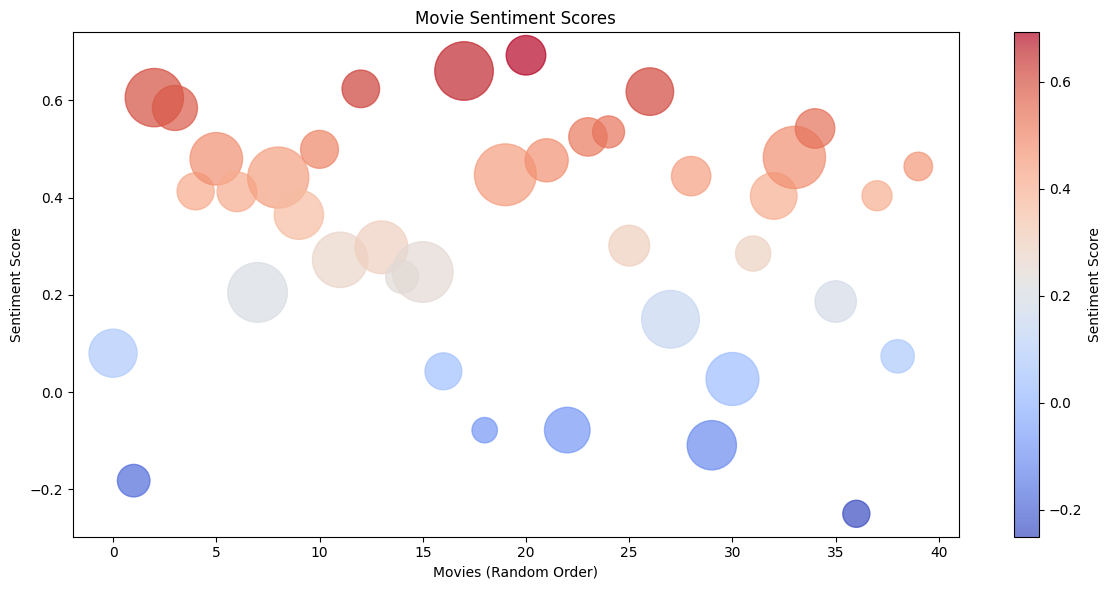

In [13]:
def visualize_sentiment(sentiment_by_movie_id, movie_data):
    # Create lists for plotting
    sentiment_scores = []
    comment_counts = []
    movie_titles = []

    for movie in movie_data:
        movie_id = movie['id']
        if movie_id in sentiment_by_movie_id:
            sentiment_scores.append(sentiment_by_movie_id[movie_id])
            comment_counts.append(int(movie['commentCount']))


    # Generate random x-axis values
    x_values = np.arange(len(sentiment_scores))

    # Create scatter plot
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        x_values,               
        sentiment_scores,       
        s=np.sqrt(comment_counts) * 10, 
        alpha=0.7,              
        c=sentiment_scores,    
        cmap='coolwarm'
    )

    # Add colorbar
    plt.colorbar(scatter, label="Sentiment Score")

    # Set plot labels and title
    plt.xlabel('Movies (Random Order)')
    plt.ylabel('Sentiment Score')
    plt.title('Movie Sentiment Scores')

    # Show plot
    plt.tight_layout()
    plt.show()

# Example call to the function
visualize_sentiment(sentiment_by_movie_id, movie_data)

Lets visualise the the relationships between our quantified trailer performance variables and the movie revenue, to visualise a possible relationship:

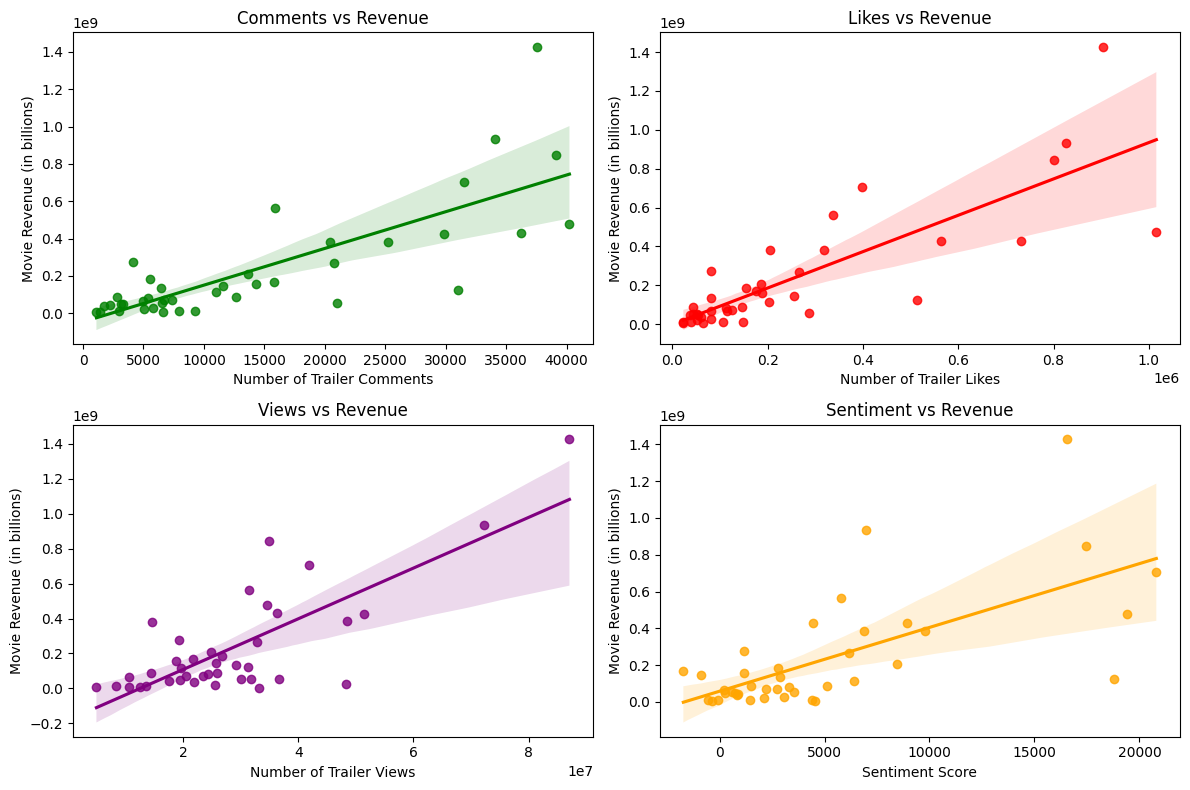

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of subplots

sns.regplot(data=data, x="trailerComments", y="revenue", ax=axes[0, 0], color="green")
axes[0, 0].set_title("Comments vs Revenue")
axes[0, 0].set_xlabel("Number of Trailer Comments")  # Custom x-axis label
axes[0, 0].set_ylabel("Movie Revenue (in billions)")  # Custom y-axis label

sns.regplot(data=data, x="trailerLikes", y="revenue", ax=axes[0, 1], color="red")
axes[0, 1].set_title("Likes vs Revenue")
axes[0, 1].set_xlabel("Number of Trailer Likes")  # Custom x-axis label
axes[0, 1].set_ylabel("Movie Revenue (in billions)")  # Custom y-axis label

sns.regplot(data=data, x="trailerViews", y="revenue", ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Views vs Revenue")
axes[1, 0].set_xlabel("Number of Trailer Views")  # Custom x-axis label
axes[1, 0].set_ylabel("Movie Revenue (in billions)")  # Custom y-axis label

sns.regplot(data=data, x="trailerSentiment", y="revenue", ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Sentiment vs Revenue")
axes[1, 1].set_xlabel("Sentiment Score")  # Custom x-axis label
axes[1, 1].set_ylabel("Movie Revenue (in billions)")  # Custom y-axis label

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

Is looks like there is indeed an upwards trend, regarding the trailer performance and the movie revenue. Lets compute a correlation matrix to see the exact correlation coefficients and the correlation between the movie trailer variables themselves, to see if they are confounding variables. 

                   revenue  trailerViews  trailerLikes  trailerSentiment  \
revenue           1.000000      0.775288      0.822540          0.677171   
trailerViews      0.775288      1.000000      0.691832          0.489045   
trailerLikes      0.822540      0.691832      1.000000          0.753487   
trailerSentiment  0.677171      0.489045      0.753487          1.000000   
trailerComments   0.788255      0.615883      0.932100          0.812721   

                  trailerComments  
revenue                  0.788255  
trailerViews             0.615883  
trailerLikes             0.932100  
trailerSentiment         0.812721  
trailerComments          1.000000  


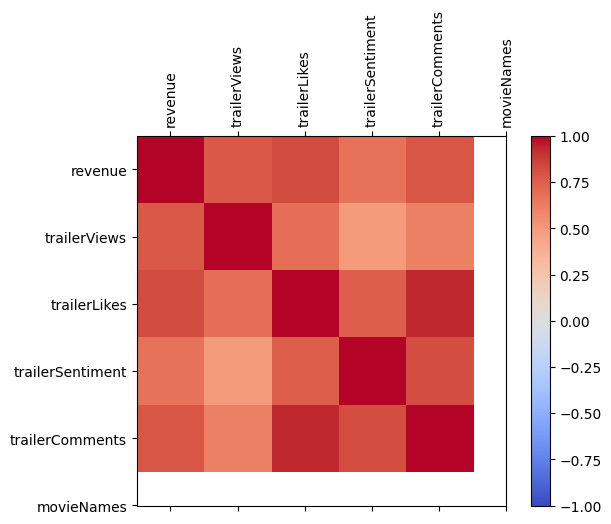

In [16]:
correlation_matrix = data.corr(numeric_only=True)
print(correlation_matrix)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation_matrix,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

## Regression model

Now lets create a linear regression model from our data, to see if we can get estimations of movie revenue, based on our trailer performce:
Note: We decided to combine our trailer variables into one variable (engagement) via Principal Component Analysis (PCA) since they correlated strongly with each other, which could work against the accuracy of the regression model.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

X = data[["trailerComments", "trailerSentiment", "trailerLikes", "trailerViews"]]
pca = PCA(n_components=1)
data["engagement"] = pca.fit_transform(X)

x = data[["engagement"]] 
y = data["revenue"]

# Linear Regression
model = LinearRegression()
model.fit(x, y)

# Coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# R-squared
r_squared = model.score(x, y)
print("R-squared:", r_squared)

Coefficients: [14.51807626]
Intercept: 230584651.92499998
R-squared: 0.6011542511842043


### Model assessment
Create an assessment graph to see visualise the residuals of our fitted model:
Note: we decided to go with a relative difference instead of an absolute difference, since absolute differences would weigh a lot heavier on movies with smaller revenues.

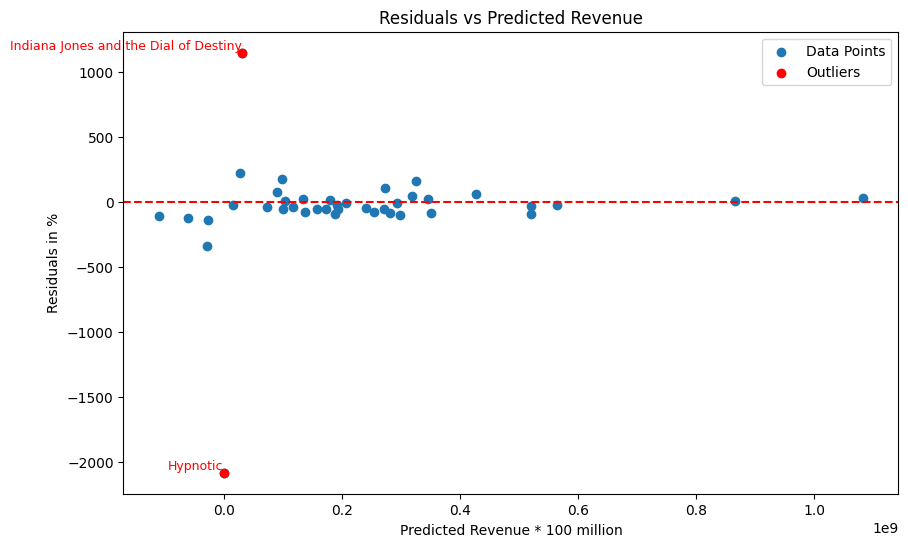

In [18]:
import matplotlib.pyplot as plt

predictions = model.predict(x)
residuals = ((y - predictions ) / predictions) * 100

# Calculate threshold for outliers
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
threshold = 1.3 * std_residual

# Identify outliers
outliers = np.abs(residuals) > threshold

lower_outliers_movie_titles = []
higher_outliers_movie_titles = []

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, label="Data Points")

# Add labels for outliers only
for i, (pred, resid, is_outlier) in enumerate(zip(predictions, residuals, outliers)):
    if is_outlier:
        plt.text(pred, resid, movie_names[i], fontsize=9, ha="right", va="bottom", color="red")
        # add outliers to lists to show them lateron
        if resid < threshold:
            lower_outliers_movie_titles.append(movie_names[i])
        else:
            higher_outliers_movie_titles.append(movie_names[i])

# Highlight outliers
plt.scatter(predictions[outliers], residuals[outliers], color="red", label="Outliers")

plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Revenue * 100 million")
plt.ylabel("Residuals in %")
plt.title("Residuals vs Predicted Revenue")
plt.legend()
plt.show()



Some more information on the outliers:

In [19]:
filtered_movies_higher = [movie for movie in movie_data if movie["title"] in higher_outliers_movie_titles]
filtered_movies_lower = [movie for movie in movie_data if movie["title"] in lower_outliers_movie_titles]
def printMovieData(movies):
    for movie in movies:
        revenue = int(movie["revenue"])
        budget = int(movie["budget"])
        ratio = revenue / budget

        print(f'{movie["revenue"]}\t {movie["budget"]}\t', ratio, f'\t{movie["title"]}')
    print()
    

print('Higher: ')
print('Revenue:\t Budget:\t Ratio: \t\t Title:')
printMovieData(filtered_movies_higher)

print('Lower: ')
print('Revenue:\t Budget:\t Ratio: \t\t Title:')
printMovieData(filtered_movies_lower)


Higher: 
Revenue:	 Budget:	 Ratio: 		 Title:
382891104	 294700000	 1.2992572242958942 	Indiana Jones and the Dial of Destiny

Lower: 
Revenue:	 Budget:	 Ratio: 		 Title:
9464308	 70000000	 0.1352044 	Hypnotic



In [20]:
def printMovieData2(movies):
    # Adjust headers to have "Title" first
    headers = ["Title", "Revenue", "Budget", "Profit", "Ratio", "ROI (%)"]
    table = []
    
    for movie in movies:
        revenue = int(movie["revenue"])
        budget = int(movie["budget"])
        ratio = revenue / budget
        profit = revenue - budget
        ROI = (profit / budget) * 100  # Return on Investment
        
        # Format large numbers with periods as thousands separators
        table.append([
            movie["title"], 
            f"{revenue:,}".replace(",", "."), 
            f"{budget:,}".replace(",", "."), 
            f"{profit:,}".replace(",", "."), 
            f"{ratio:.3f}", 
            f"{ROI:.3f}"
        ])
    
    # Print table
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print()
    

printMovieData2(movie_data)
print('Higher outliers: ')
printMovieData2(filtered_movies_higher)

print('Lower outliers: ')
printMovieData2(filtered_movies_lower)

+-----------------------------------------------+---------------+-------------+---------------+---------+-----------+
| Title                                         | Revenue       | Budget      | Profit        |   Ratio |   ROI (%) |
+===============================================+===============+=============+===============+=========+===========+
| The Equalizer 3                               | 158.300.000   | 70.000.000  | 88.300.000    |   2.261 |   126.143 |
+-----------------------------------------------+---------------+-------------+---------------+---------+-----------+
| Retribution                                   | 12.905.464    | 20.000.000  | -7.094.536    |   0.645 |   -35.473 |
+-----------------------------------------------+---------------+-------------+---------------+---------+-----------+
| Blue Beetle                                   | 124.818.235   | 120.000.000 | 4.818.235     |   1.04  |     4.015 |
+-----------------------------------------------+-------